**Processamento Digital de Imagens - 2022/01**<br/>
**Engenharia da Computação**<br/>
**Alunos:** Gabriel Soares Baptista, 2018102117 e Humberto Giuri Calente, 2018103846<br/>

### Questão 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict

### Funções Auxiliares

In [3]:
def image_histogram(image: np.array) -> None:
    """
    Plota um histograma de uma imagem 'uint8' informada como
    um np.array.
    """
    histogram = {i: 0 for i in range(256)}

    for row in image:
        for pixel in row:
            histogram[pixel] += 1

    plt.bar(histogram.keys(), histogram.values())
    plt.show()


def binary_image(image: np.array, threshold: float) -> np.array:
    """
    Binariza uma imagem baseada em um valor de threshold informado,
    isto é, percorrendo cada pixel da imagem, se o pixel atual tiver
    intensidade maior que o threshold o novo valor será 1, 0 caso
    contrário.
    Retorna um np.array 'uint8' representando a imagem de entrada
    binarizada.
    """
    return np.where(image > threshold, 1, 0)


def plot_comparision(
    im0: np.array,
    im1: np.array,
    titles: Tuple[str, str] = ('', '')) -> None:
    """
    Plota um subplot com as duas imagens informadas. O parâmetro
    de títulos é opcional.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(im0, cmap='gray')
    axs[0].set_title(titles[0])
    axs[1].imshow(im1, cmap='gray')
    axs[1].set_title(titles[1])
    plt.show()

### Algoritmo para nomear componentes conectados

In [4]:
def connected_components_labeling(image: np.array) -> np.array:
    """
    Percorre a imgem, definindo os elementos que estão conectados.
    A conexão dos pontos é feita considerando a adjacência 8.
    """
    image = np.pad(image, 1)
    m, n = image.shape
    labeled = np.zeros(shape=(m, n))

    # Define o próximo label a ser utilizado
    next_label = 1

    # Dicionário contendo as equivalências de labels
    equivalency = {}

    # Verifica as adjacências
    for i in range(1, m - 1):
        for j in range(1, n - 1):
            if image[i][j] == 1:
                # Verifica os labels
                labels = [
                    labeled[i-1][j-1],
                    labeled[i-1][j],
                    labeled[i-1][j+1],
                    labeled[i][j-1]]

                # Verifica quantos pixels adjacentes com rótulo
                # existem
                if sum(labels) == 0:
                    # Nenhum, define um novo rótulo
                    labeled[i][j] = next_label
                    next_label += 1

                elif sum([1 for xi in labels if xi != 0]) == 1:
                    # Um elemento não zero, recebe o rótulo do 
                    # vizinho rotulado
                    labeled[i][j] = sum(labels)
                
                else:
                    # Mais de um elemento não-zero, recebe o
                    # menor rótulo, o restante e anotado na lista
                    # de equivalências 
                    labels = [xi for xi in labels if xi != 0]
                    labels = sorted(labels)
                    min_val = labels[0]

                    # Grava como o menor
                    labeled[i][j] = min_val

                    # Grava na lista de equivalências
                    for k in range(1, len(labels)):
                        if labels[k] != min_val:
                            equivalency[labels[k]] = min_val

    # Efetua a troca pela lista de equivalências
    for i in range(1, m - 1):
        for j in range(1, n - 1):
            if labeled[i][j] in equivalency:
                labeled[i][j] = equivalency[labeled[i][j]]

    return np.array(labeled, dtype='uint8')

Assumindo uma adjacência 8. Movemos de um ponto p (denotado pelo pixel que será nomeado no processo de escaneamento) para cada pixel em V = {1}. Se o pixel estiver em V, examinamos a vizinhança de p, onde temos as seguintes operações:
- Caso todos vizinhos sejam 0, definimos um novo label.
- Se apenas um vizinho estiver em V = {1}, definimos o mesmo label do vizinho para o pixel.
- Se mais de um vizinho estiver em V = {1}, definimos o menor label e fazemos a anotação para efetuar a correção de equivalência.

### Funções utilizadas para melhorar e/ou limpar o resultado

In [5]:
def reindex_labels(labels: Dict[int, int]) -> Dict[int, int]:
    """
    Refaz a indexação dos ids dos labels, isto é, faz com que os labels
    existentes sigam a sequencial dos números naturais.
    """
    current_index = 0
    new_labels = labels.copy()

    for index in labels.keys():
        if index != current_index:
            new_labels[current_index] = new_labels.pop(index)
        current_index += 1
    
    return new_labels


def get_labels(image: np.array) -> Dict[int, int]:
    """
    Percorre a imagem resultante, contando a área de cada
    conjunto, isto é, quantos pixels existem para cada label
    definido.
    """
    labels = np.unique(image).tolist()
    new_labels = {i: 0 for i in labels}

    m, n = image.shape

    for i in range(m):
        for j in range(n):
            new_labels[image[i][j]] += 1

    return new_labels


def remove_outliers(labels: Dict[int, int]) -> Dict[int, int]:
    """
    Remove os labels que tenham uma quantidade de pontos menor
    do que um desvio padrão da média.
    """
    # Remove o label zero, pois é o label do fundo
    labels_qtd = np.array(list(labels.values()))[1:]

    # Copia os labels sem o zero
    new_labels = labels.copy()

    # Caso o valor esteja mais distante que um desvio padrão da média,
    # apenas pelo desvio inferior, o valor é removido.
    for key, value in labels.items():
        if value < labels_qtd.mean() - labels_qtd.std():
            new_labels.pop(key)

    return new_labels


### Aplicando o algoritmo

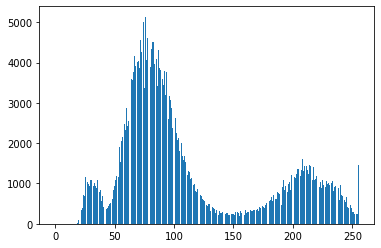

In [6]:
image = plt.imread('../images/Fig8.02.jpg')
image_histogram(image)

Pelo histograma acima, observa-se que um valor em torno de 150 irá dividir bem a quantidade de pixels da imagem, nos fornecendo um bom valor para utilizar como limiar de separação da área com menor intensidade (região mais escura) da área com maior intensidade (região clara, nesse caso o corpo dos fósforos). Entretanto, buscando fornecer uma margem de erro, utilizamos o valor de 165 como limiar.

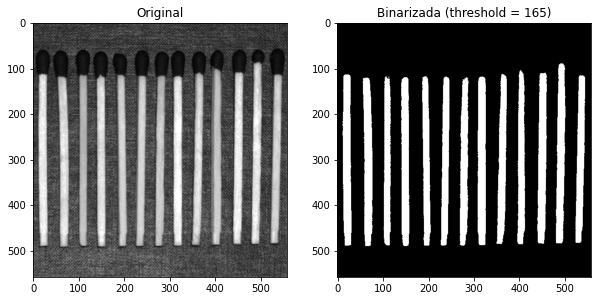

In [7]:
bimage = binary_image(image, 165)

# Plota a comparação da imagem original e binarizada
plot_comparision(image, bimage, (
    'Original', 'Binarizada (threshold = 165)'))

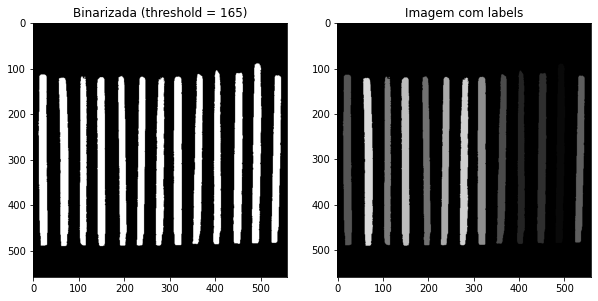

In [8]:
labeled_image = connected_components_labeling(bimage)

# Plota a comparação entre a imagem binarizada e a imagem com os labels
plot_comparision(bimage, labeled_image, (
    'Binarizada (threshold = 165)', 'Imagem com labels'))

É interesante notar que a plotagem modifica o intervalo das intensidades, fornecendo-se uma plotagem mais adequada. Nesse contexto, conseguimos visualizar cada palito com uma label diferente. Entretanto, iremos remover os outliers (labels com poucos  pixels associados), para isso, pegamos apenas os palitos com área maior que `média - 1 * desvio_padrão`.

In [9]:
labels = get_labels(labeled_image)
labels = remove_outliers(labels)
labels = reindex_labels(labels)

In [10]:
print('Área dos palitos:')

for  key, value in labels.items():
    if key == 0: continue
    print(f'Palito {key} = {value}')

Área dos palitos:
Palito 1 = 6303
Palito 2 = 5235
Palito 3 = 6261
Palito 4 = 5645
Palito 5 = 6255
Palito 6 = 5531
Palito 7 = 5227
Palito 8 = 4999
Palito 9 = 6357
Palito 10 = 5371
Palito 11 = 5965
Palito 12 = 5569
Palito 13 = 6269


Observa-se que o algoritmo foi capaz de detectar a quantidade exata de palitos, quanto a área de cada um, os valores devem ser próximos de outra execuções, entretanto, está atrelado diretamete ao valor escolhido como limiar para binarizar a imagem, podem gerar pequenos desvios.